# *Salix nigra* SLR: Variants
Brian J. Sanderson

Last updated: 27 Mar 2020

In [1]:
# Libraries used in this notebook (R 3.6.2)

suppressMessages(library(tidyverse))
suppressMessages(library(cowplot))
suppressMessages(library(viridis))

## Variant identification and hard filtering with GATK 4.0.8.1

**Note**: Most of the following is derived from [this guide](http://evodify.com/gatk-the-best-practice-for-genotype-calling-in-a-non-model-organism/). The code from that website has been modified for use with GATK v 4.0.8.1 (the syntax is moderately different). 

This notebook begins on the HPCC using analysis-ready BAM alignments, as well as a list of intervals of 100,000 bp intervals across the genome, which are the end result of the notebook titled [*Salix nigra* SLR: Alignments](https://github.com/BrianSanderson/salix-nigra-slr/blob/master/notebooks/Salix-nigra-SLR-01-Alignments.ipynb).

### Create the directory structure on the scratch drive

I've encountered issues in the past when jobs are writing many results simultaneously to non-scratch space on the TTU HPCC, and so I have all of these scripts write out to the temporary space on /lustre/scratch. To make the following more general, I will replace the absolute directory to the scratch space with ```${SCRATCH}```. I will also replace the absolute path to my non-scratch work directory with ```${WORK}```.

First, a main project directory:

```bash
# BASH code

mkdir ${SCRATCH}/snigra/
```

Second, a set of directories for the GVCF files, one for each indivdual:

```bash
# BASH code

mkdir ${SCRATCH}/snigra/gvcf/
while read -r i; do mkdir ${SCRATCH}/snigra/gvcf/"$i"; done < namelist.txt
```

Third, a set of directories for the log files generated by the GVCF step, one for each individual:

```bash
# BASH code

mkdir ${SCRATCH}/snigra/log/
while read -r i; do mkdir ${SCRATCH}/snigra/log/"$i"; done < namelist.txt
```

The file ```namelist.txt``` is just a list of the IDs of each library (e.g. "SN502F"), one on each line


## Call variants on all individuals as GVCFs

Quantifying GVCFs for regions of 100,000 bp across each contig in the v5 pacbio assembly, for all individuals

```bash
# HPC submission script

#!/bin/sh
#$ -V
#$ -cwd
#$ -t 1-3351:1
#$ -S /bin/bash
#$ -N snigra-gvcf-ARGLE
#$ -q omni
#$ -pe sm 1
#$ -P quanah
#$ -e ${SCRATCH}/snigra/log/ARGLE/$JOB_NAME.e$JOB_ID.$TASK_ID
#$ -o ${SCRATCH}/snigra/log/ARGLE/$JOB_NAME.o$JOB_ID.$TASK_ID

prefixNum="$SGE_TASK_ID"
prefixNumP="$prefixNum"p
prefix=`sed -n "$prefixNumP" salixIntervals.list`

gatk HaplotypeCaller \
    -R ${WORK}/genomes/Salix_purpurea_var_94006.mainGenome-noZ.fasta \
    -L "$prefix" \
    -I dBAM/ARGLE.dedup.bam \
    -ERC GVCF \
    --heterozygosity 0.015 \
    --indel-heterozygosity 0.01 \
    -O ${SCRATCH}/snigra/gvcf/ARGLE/ARGLE."$prefix".g.vcf
```

The variable "ARGLE" is used so that I can issue the script separately for each of the 48 libraries using the following command:

```bash
# BASH code

while read -r i; 
    do sed -i "s/ARGLE/$i/g" 01-Individual-GVCF.sh; qsub 01-Individual-GVCF.sh; 
    sed -i "s/$i/ARGLE/g" 01-Individual-GVCF.sh; 
done < namelist.txt
```

where ```namelist.txt``` is a file with 48 lines, and each line is the name of a library without any file extension (e.g. "SN502F"). 

This issues 48 task arrays, each with 3,351 jobs, so all together it is 160,848 jobs. This may be regarded as an anti-social act, depending on the HPCC environment where you are working.

### Merge individual GVCFs for each library.

This script is very messy, and a bit embarrassing. However, it is honest because this is how I performed this analysis. I need to come up with a more elegant solution. What the following code does is generate an incredibly long script that contains one ```--variant``` line for each of the 3351 intervals across the genome, and then another line for each of the chromosomes and contigs to stich them together at the end. As far as I can tell it is not possible to pass this GATK tool a list, so this was the solution I came up with.

First, need to create a list of the chromosomes:

```bash
# BASH code

grep ">" ../genomes/Salix_purpurea_var_94006.mainGenome-noZ.fasta | sed -e 's/>//g' > chrom.list

```

The script should have the following header which you can create with a text editor. For the purposes of this examile the file name is ```02-Merge-Individual-Intervals.sh```

```bash
# HPC submission script

#!/bin/sh
#$ -V
#$ -cwd
#$ -t 1-48:1
#$ -S /bin/bash
#$ -N snigra-merge-individuals
#$ -q omni
#$ -o log/02/$JOB_NAME.o$JOB_ID.$TASK_ID
#$ -e log/02/$JOB_NAME.e$JOB_ID.$TASK_ID
#$ -pe sm 1
#$ -P quanah

prefixNum="$SGE_TASK_ID"
prefixNumP="$prefixNum"p
prefix=`sed -n "$prefixNumP" allnames.txt`
```

Then iterate through all of the chromosomes and intervals to add the lines necessary for the combination.

First, the sets of CombineGVCF commands for each chromosome or scaffold, separately:

```bash
# BASH code
while read -r i; 
    do printf "gatk CombineGVCFs\n    -R ${WORK}/Salix_purpurea_var_94006.mainGenome-noZ.fasta\n" | \
    sed -e 's/$/ \\/g' >> 02-Merge-Individual-Intervals.sh; 
    grep "$i" salixIntervals.list | \
    sed -e 's/^/    --variant \${SCRATCH}\/snigra\/gvcf\/\"$prefix\"\/\"$prefix\"./g;s/$/.g.vcf \\/' >> \
    02-Merge-Individual-Intervals.sh; 
    printf "    --output ${SCRATCH}/briasand/snigra/gvcf/\"\$prefix\"/\"\$prefix\".$i.g.vcf\n" >> \
    02-Merge-Individual-Intervals.sh; 
    printf "\n" >> 02-Merge-Individual-Intervals.sh; 
done < chrom.list
```

Then, combine all of the chromosomes and scaffolds together for a single GVCF file for each individual:
```bash
# BASH code

printf "gatk CombineGVCFs\n    -R ${WORK}/Salix_purpurea_var_94006.mainGenome-noZ.fasta\n" | \
    sed -e 's/$/ \\/g' >> 02-Merge-Individual-Intervals.sh

while read -r i; 
    do printf "    --variant ${SCRATCH}/snigra/gvcf/\"\$prefix\"/\"\$prefix\".$i.g.vcf\n" | \
    sed -e 's/$/ \\/g' >> 02-Merge-Individual-Intervals.sh; 
done < chrom.list

printf "    --output ${SCRATCH}/snigra/gvcf/\"\$prefix\".g.vcf\n" >> \
    02-Merge-Individual-Intervals.sh
```

In the end, it should look like this: 

```bash
# HPC submission script

#!/bin/sh
#$ -V
#$ -cwd
#$ -t 1-48:1
#$ -S /bin/bash
#$ -N snigra-merge-individuals
#$ -q omni
#$ -o log/02/$JOB_NAME.o$JOB_ID.$TASK_ID
#$ -e log/02/$JOB_NAME.e$JOB_ID.$TASK_ID
#$ -pe sm 1
#$ -P quanah

prefixNum="$SGE_TASK_ID"
prefixNumP="$prefixNum"p
prefix=`sed -n "$prefixNumP" allnames.txt`


gatk CombineGVCFs  \
    -R ${WORK}/genomes/Salix_purpurea_var_94006.mainGenome.fasta \
    --variant ${SCRATCH}/snigra/gvcf/"$prefix"/"$prefix".Chr01:1-100000.g.vcf \
    --variant ${SCRATCH}/snigra/gvcf/"$prefix"/"$prefix".Chr01:100001-200000.g.vcf \
    --variant ${SCRATCH}/snigra/gvcf/"$prefix"/"$prefix".Chr01:200001-300000.g.vcf \
    --variant ${SCRATCH}/snigra/gvcf/"$prefix"/"$prefix".Chr01:300001-400000.g.vcf \
    --variant ${SCRATCH}/snigra/gvcf/"$prefix"/"$prefix".Chr01:400001-500000.g.vcf \


# Many many more lines...

    --variant ${SCRATCH}/snigra/gvcf/"$prefix"/"$prefix".scaffold_772.g.vcf \
    --variant ${SCRATCH}/snigra/gvcf/"$prefix"/"$prefix".scaffold_773.g.vcf \
    --variant ${SCRATCH}/snigra/gvcf/"$prefix"/"$prefix".scaffold_777.g.vcf \
    --variant ${SCRATCH}/snigra/gvcf/"$prefix"/"$prefix".scaffold_844.g.vcf \
    --output ${SCRATCH}/snigra/gvcf/"$prefix".g.vcf
```

The reason that I'm combining the chromsomes/scaffolds separately, and then combining them together, rather than doing it all in one step, is that the jobs kept ending early with no error message, so I became concerned that combining 3,351 GCVFs at once was too memory-intensive.

### Combine the individual GVCFs into a genomics database for all individuals

To make this script less cumbersome, it accepts a sample_map file that contains the list of gvcfs that need to be combined into a database for all individuals. (WHY doesn't CombineGVCFs?)

```bash
# BASH code

while read -r i; 
    do printf "$i\t${SCRATCH}/snigra/gvcf/$i.g.vcf\n"; 
done < allnames.txt > all.sample_map
```

This script will take the all.sample_map file and import all of the 48 combined GVCFs from the previous step into a genomics tile database, which will be used to call the variants in the next step.

```bash
# HPC submission script

#!/bin/sh
#$ -V
#$ -cwd
#$ -S /bin/bash
#$ -N snigra-merge
#$ -q omni
#$ -o log/03/$JOB_NAME.o$JOB_ID
#$ -e log/03/$JOB_NAME.e$JOB_ID
#$ -pe sm 1
#$ -P quanah

gatk --java-options "-Xmx4g -Xms4g" GenomicsDBImport \
    --sample-name-map all.sample_map \
    --genomicsdb-workspace-path ${SCRATCH}/snigra/genodb \
    -L salixIntervals.list
```

### Create a genotype file that summarizes the variants in each GVCF file

```bash
# HPC submission script

#!/bin/sh
#$ -V
#$ -cwd
#$ -S /bin/bash
#$ -N snigra-genotype
#$ -q omni
#$ -o log/$JOB_NAME.o$JOB_ID
#$ -e log/$JOB_NAME.e$JOB_ID
#$ -pe sm 1
#$ -P quanah

gatk --java-options "-Xmx5g -Xms5g" GenotypeGVCFs \
    -R Salix_purpurea_var_94006.mainGenome.fasta \
    -O ${SCRATCH}/snigra/gvcf/all.genotypes.raw.vcf \
    -G StandardAnnotation \
    --use-new-qual-calculator \
    -V gendb://${SCRATCH}/snigra/genodb \
    --heterozygosity 0.015 \
    --indel-heterozygosity 0.01 \
    --stand-call-conf 30.0
```

I then transfered the genotype VCF file to a private Linux server for further processing (i.e. where SLURM submission scripts are not necessary)

## Hard filtering of SNPs using GATK 4.0.8.1

Because we lack the necessary "gold standard" information about all variant sites in the *Salix* genome to use
the more advanced VQSR methods in GATK, we instead rely on hard filtering to select the high confidence variants
that we use downstream for analysis. We are using guidance from the [GATK forums here](https://gatkforums.broadinstitute.org/gatk/discussion/6925/understanding-and-adapting-the-generic-hard-filtering-recommendations) to guide the selection of filtering criteria.

### Extract SNPs from the set of genotypes derived from the GVCFs

The parameter ```-sn names.args``` references a file that contains the names of 48 individuals.

```bash
# BASH code

gatk SelectVariants \
    -R Salix_purpurea_var_94006.mainGenome-noZ.fasta \
    -V snigra.genotypes.all.vcf \
    --select-type SNP \
    -sn names.args \
    -O snigra.genotypes.snp.vcf
```

### Extract some information about the SNP sites to estimate site filtering criteria

```bash
# BASH code

gatk VariantsToTable \
    -R Salix_purpurea_var_94006.mainGenome-noZ.fasta \
    -V snigra.genotypes.snp.vcf \
    -F CHROM -F POS -F QUAL -F QD -F DP -F MQ -F MQRankSum -F FS -F ReadPosRankSum -F SOR \
    -O snigra.genotypes.snp.table
```

### Do the same with the indel sites

```bash
# BASH code

gatk SelectVariants \
    -R Salix_purpurea_var_94006.mainGenome-noZ.fasta \
    -V snigra.genotypes.all.vcf \
    --select-type INDEL \
    -sn parents.args \
    -O snigra.genotypes.indel.vcf

gatk VariantsToTable \
    -R Salix_purpurea_var_94006.mainGenome-noZ.fasta \
    -V snigra.genotypes.indel.vcf \
    -F CHROM -F POS -F QUAL -F QD -F DP -F MQ -F MQRankSum -F FS -F ReadPosRankSum -F SOR \
    -O snigra.genotypes.indel.table
```

### Read the SNP and indel tables into R to summarize the distribution of quality scores:

In [2]:
VCFsnps <- read_delim("snigra.genotypes.snp.table", na=c("", "NA"), delim="\t")
VCFindel <- read_delim("snigra.genotypes.indel.table", na=c("", "NA"), delim="\t")

Parsed with column specification:
cols(
  CHROM = col_character(),
  POS = col_double(),
  QUAL = col_double(),
  QD = col_double(),
  DP = col_double(),
  MQ = col_double(),
  MQRankSum = col_double(),
  FS = col_double(),
  ReadPosRankSum = col_double(),
  SOR = col_double()
)

Parsed with column specification:
cols(
  CHROM = col_character(),
  POS = col_double(),
  QUAL = col_double(),
  QD = col_double(),
  DP = col_double(),
  MQ = col_double(),
  MQRankSum = col_double(),
  FS = col_double(),
  ReadPosRankSum = col_double(),
  SOR = col_double()
)



Create a combined dataframe containing both SNPs and indels

In [3]:
VCF <- rbind(VCFsnps, VCFindel)
VCF$Variant <- factor(c(rep("SNPs", dim(VCFsnps)[1]), rep("Indels", dim(VCFindel)[1])))

Options for plotting in Jupyter

In [4]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 300)
theme_set(theme_cowplot()); theme_update(plot.title = element_text(hjust = 0.5))

Plot combined depth per SNP across samples (log scale, so 0 values missing). We won't actually use the depth criteria at
the moment for filtering, but it is interesting.

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 54938 rows containing non-finite values (stat_density).”


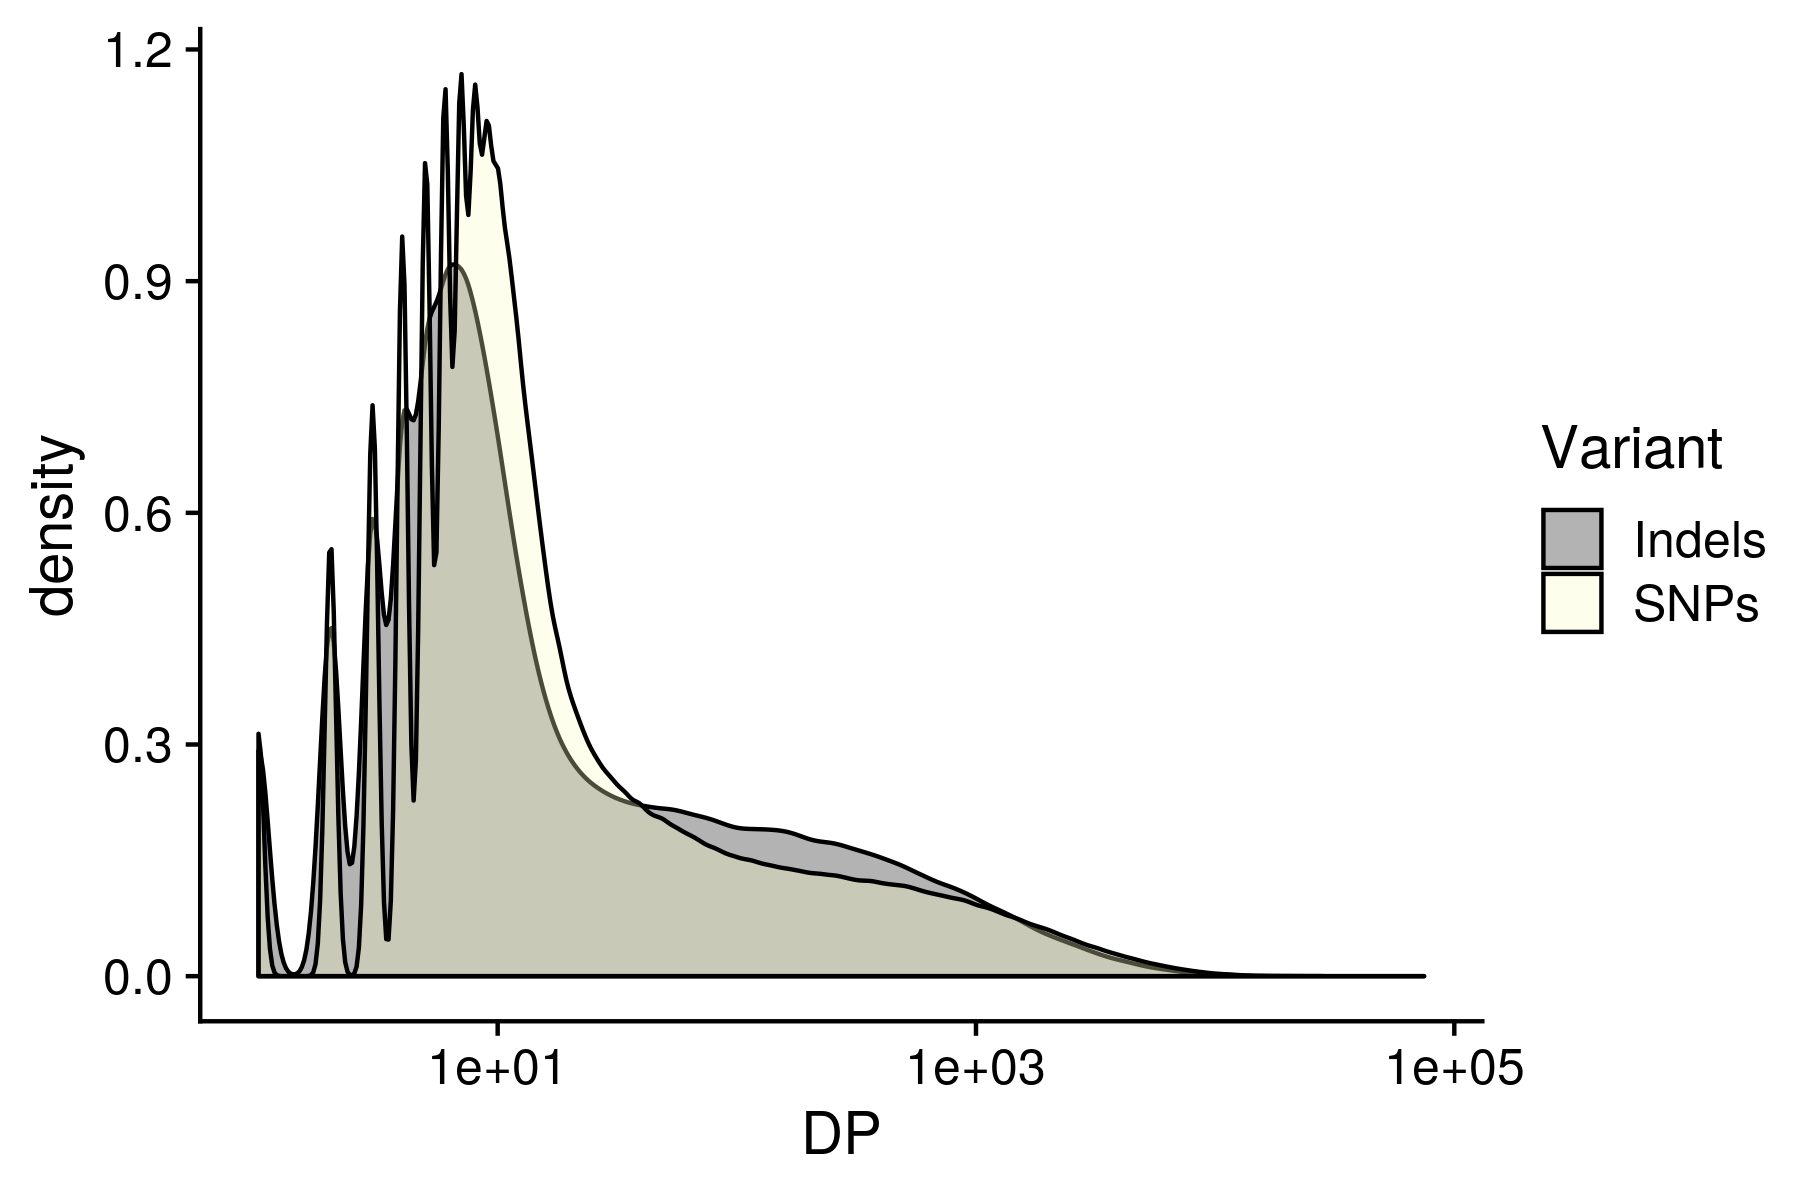

In [5]:
ggplot(VCF, aes(x=DP, fill=Variant)) +
    geom_density(alpha=0.3) +
    scale_x_continuous(trans='log10') +
    scale_fill_viridis(discrete = TRUE, option = "magma")

Plot variant confidence standardized by depth. This is the basis for the **QD** parameter. Based on the plot below,
we will use **QD** < 2. This is the value suggested [here](https://gatkforums.broadinstitute.org/gatk/discussion/6925/understanding-and-adapting-the-generic-hard-filtering-recommendations). However, we have a worrying peak around QD values of 20 which I'm concerned may
correspond to a similar shoulder in the data from that forum discussion. I'm going to proceed with a value of 2 for now, but may need to revisit.

Warning message:
“Removed 17362 rows containing non-finite values (stat_density).”


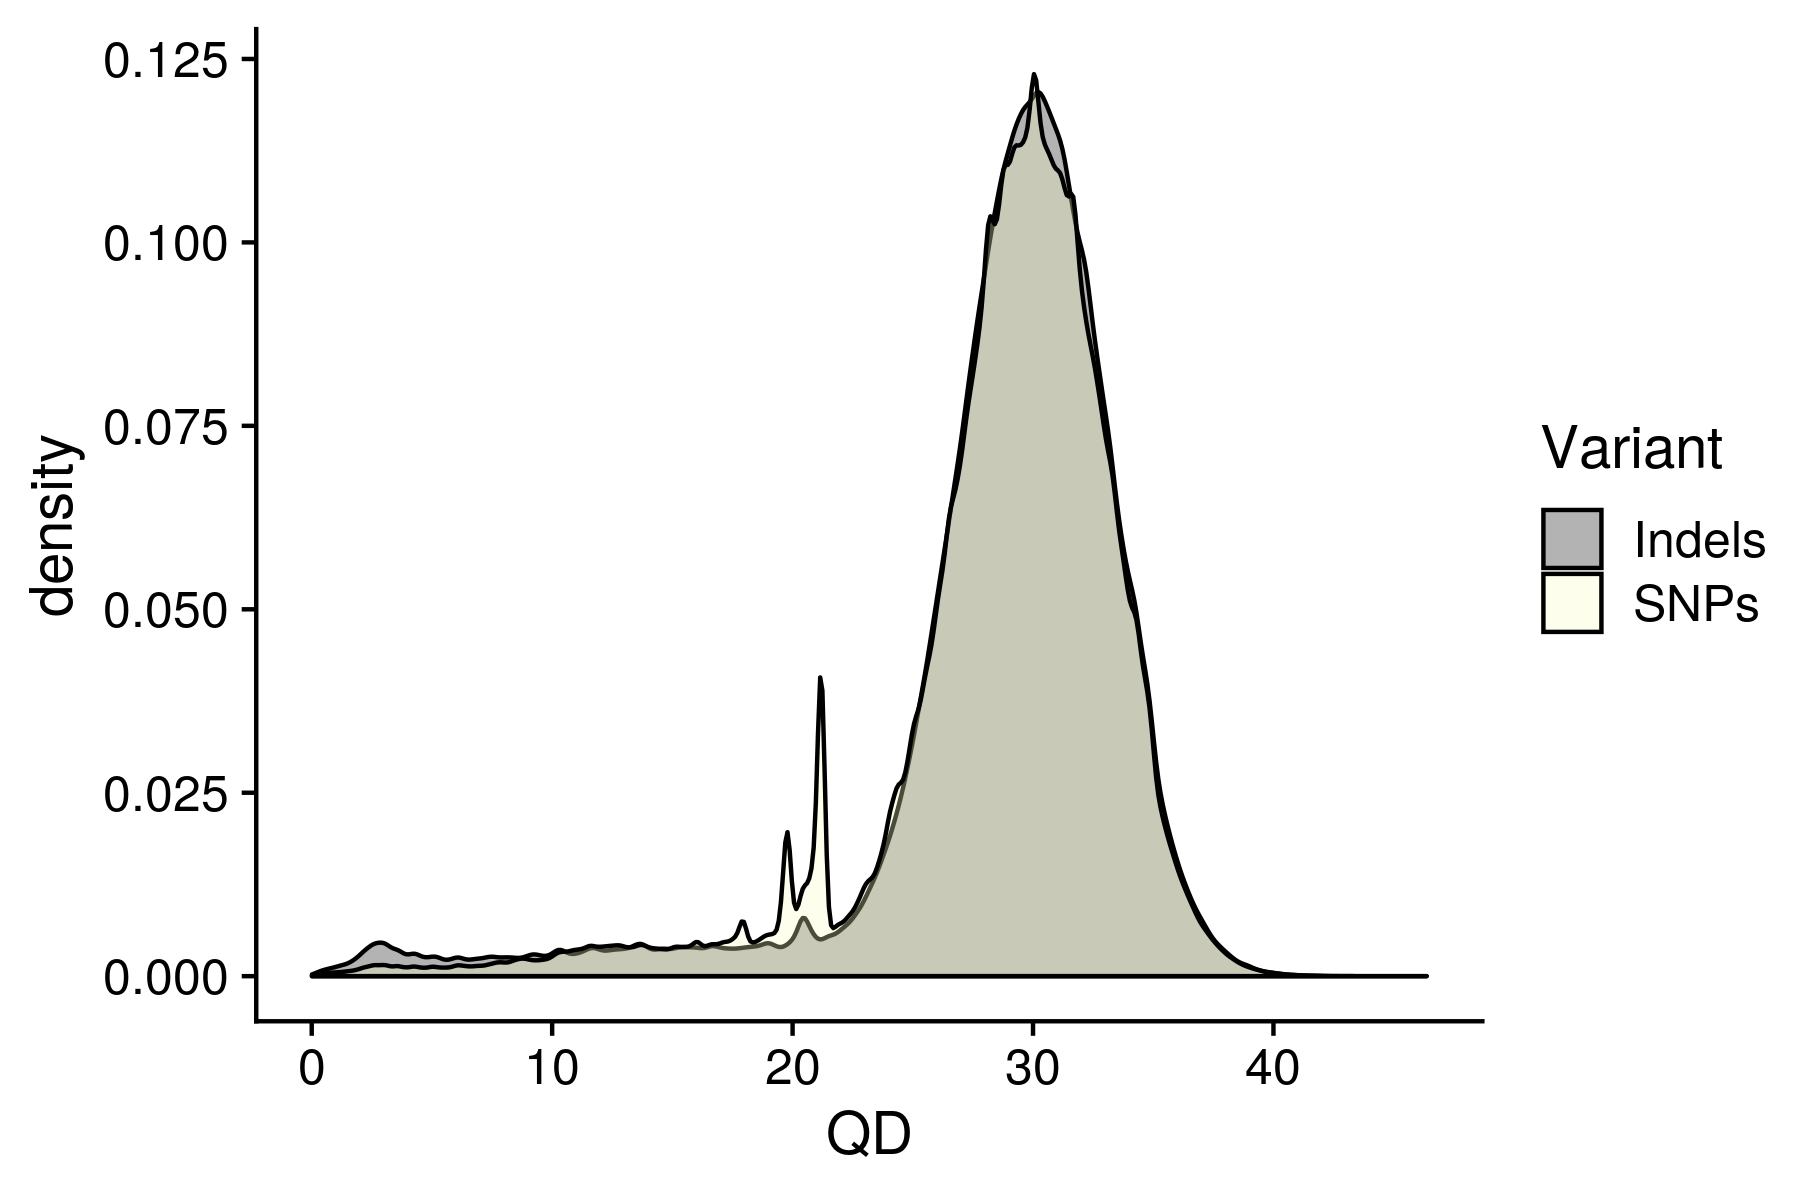

In [6]:
ggplot(VCF, aes(x=QD, fill=Variant)) +
    geom_density(alpha=.3) +
    scale_fill_viridis(discrete = TRUE, option = "magma")

Plot strand bias in support for REF vs ALT allele calls using a Fisher's exact test 
(i.e. whether an ALT allele is more likely to be  on the forward or reverse strand, 
and this should ideally be close to 0). This is the basis for the **FS** parameter, and based on the
distribution below, I will use **FS** > 60.

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 7484994 rows containing non-finite values (stat_density).”


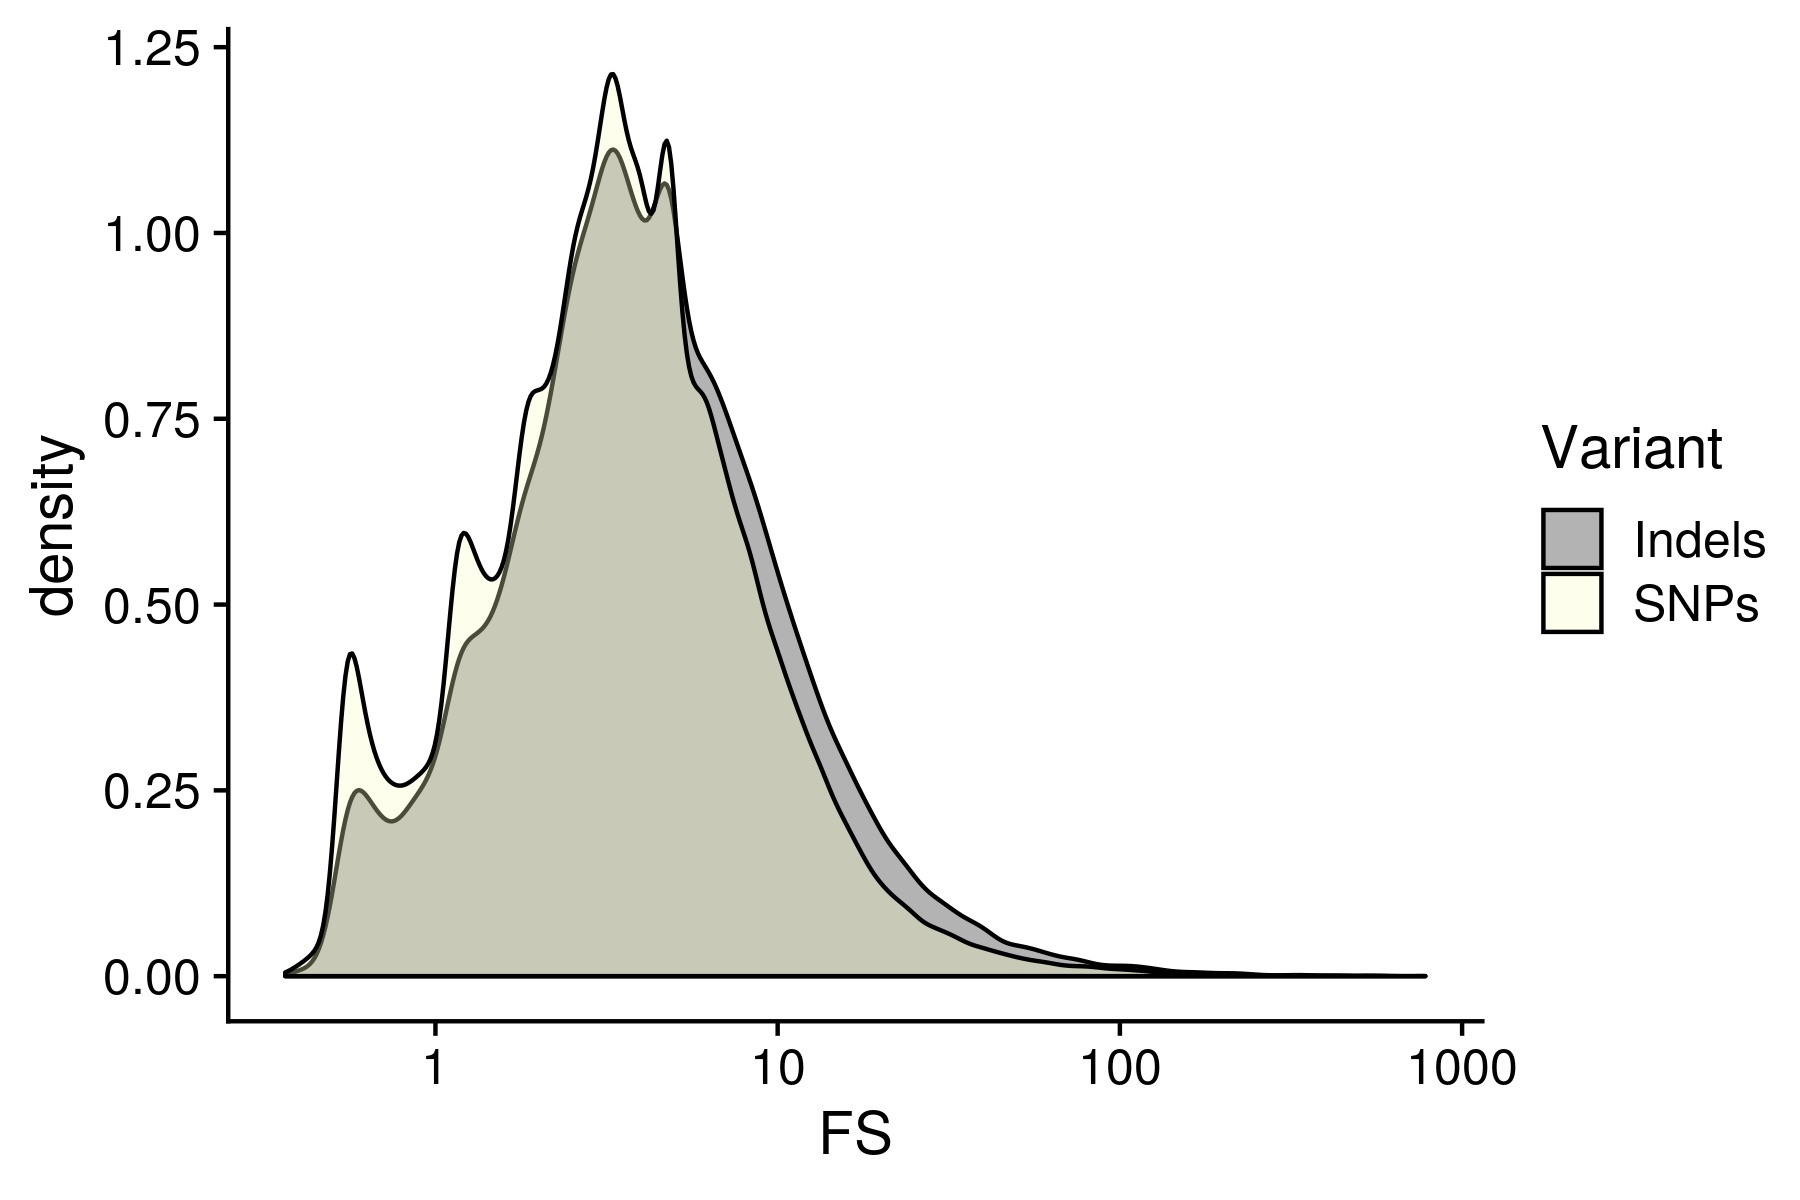

In [7]:
ggplot(VCF, aes(x=FS, fill=Variant)) +
    geom_density(alpha=.3) +
    scale_x_continuous(trans='log10') +
    scale_fill_viridis(discrete = TRUE, option = "magma")

Plot sequencing bias in which one DNA strand is favored over the other using a symmetric odds ratio test.
This is another way of calculating strand bias similar to the metric above. This is the basis for the **SOR** 
parameter, and based on this distribution I will use **SOR** > 3 

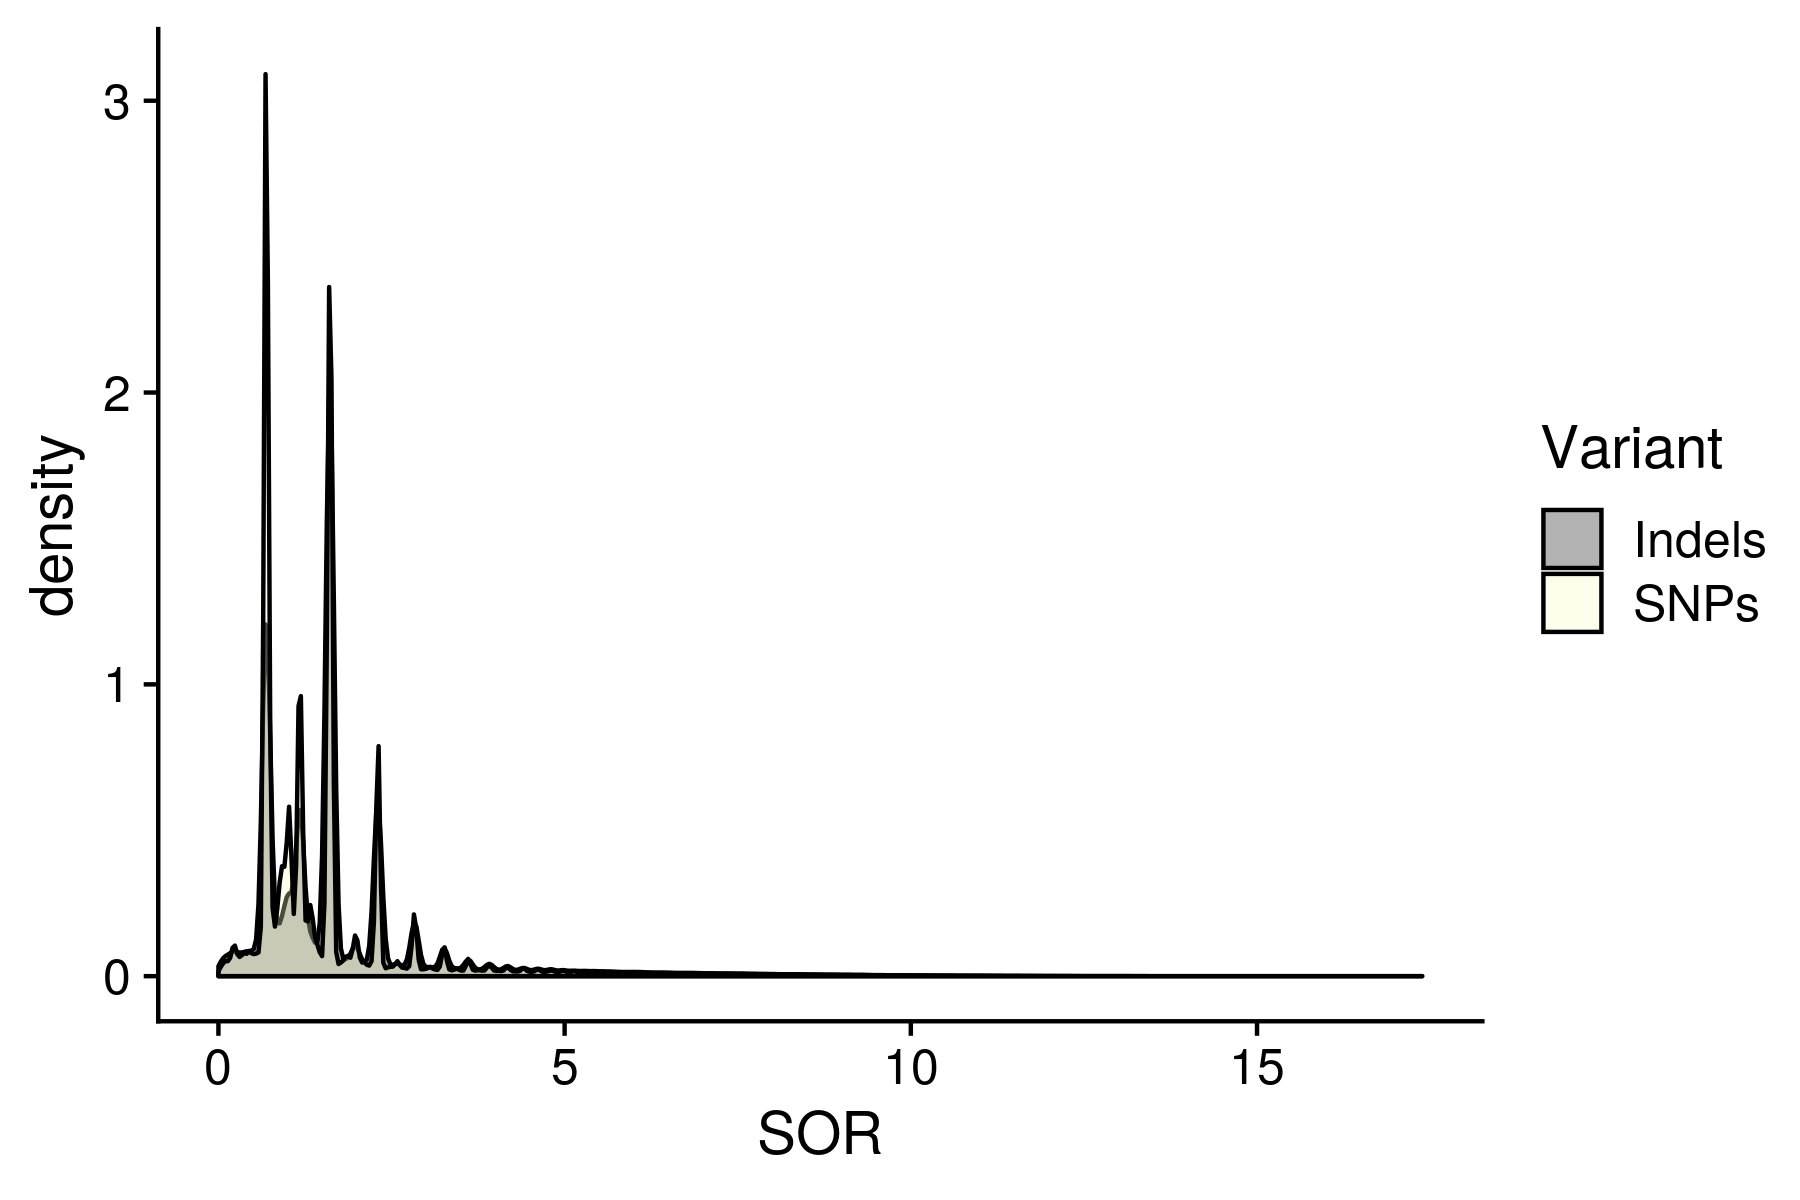

In [8]:
ggplot(VCF, aes(x=SOR, fill=Variant)) + 
    geom_density(alpha=.3) +
    scale_fill_viridis(discrete = TRUE, option = "magma")

Plot mapping quality as the root mean square quality over all reads at the site. This is the basis of the **MQ**
parameter, and based on [these recommendations](https://gatkforums.broadinstitute.org/gatk/discussion/6925/understanding-and-adapting-the-generic-hard-filtering-recommendations) I will use **MQ** < 40. I'm concerned this may be too strict based on the distribution
below, because this distribution does not resemble the distribution from the recommendations, but we can always
revisit these parameters as necessary.

Warning message:
“Removed 16835 rows containing non-finite values (stat_density).”


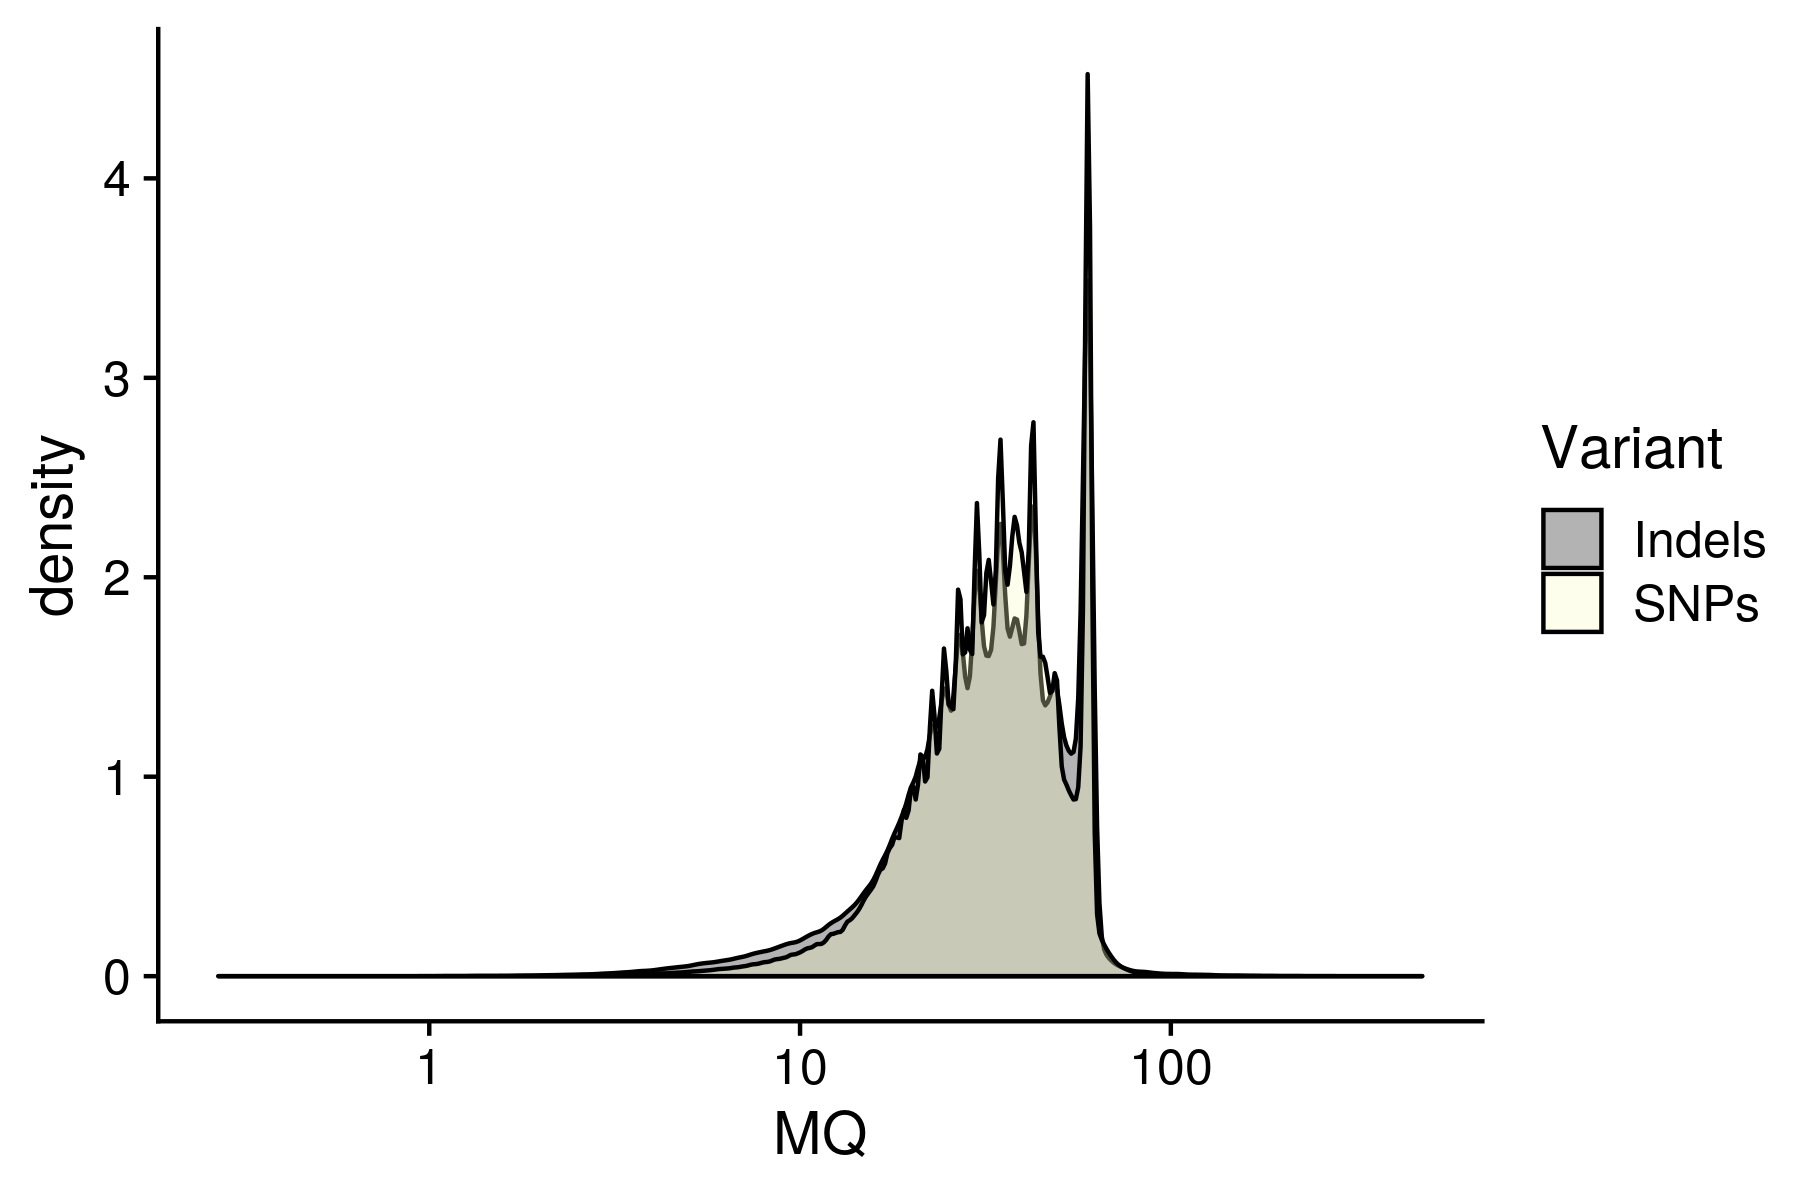

In [9]:
ggplot(VCF, aes(x=MQ, fill=Variant)) +
    geom_density(alpha=.3) +
    scale_x_continuous(trans='log10') +
    scale_fill_viridis(discrete = TRUE, option = "magma")

Plot rank sum test for mapping qualities of REF vs. ALT reads. Similar to above metrics, but uses a u-based
z-approximation from the Rank Sum Test to compare mapping qualities of reads supporting reference vs 
non-reference alleles. This is the basis of the **MQRankSum** parameter, and based on this distribution
I will use **MQRankSum** < -12.500

Warning message:
“Removed 6834002 rows containing non-finite values (stat_density).”


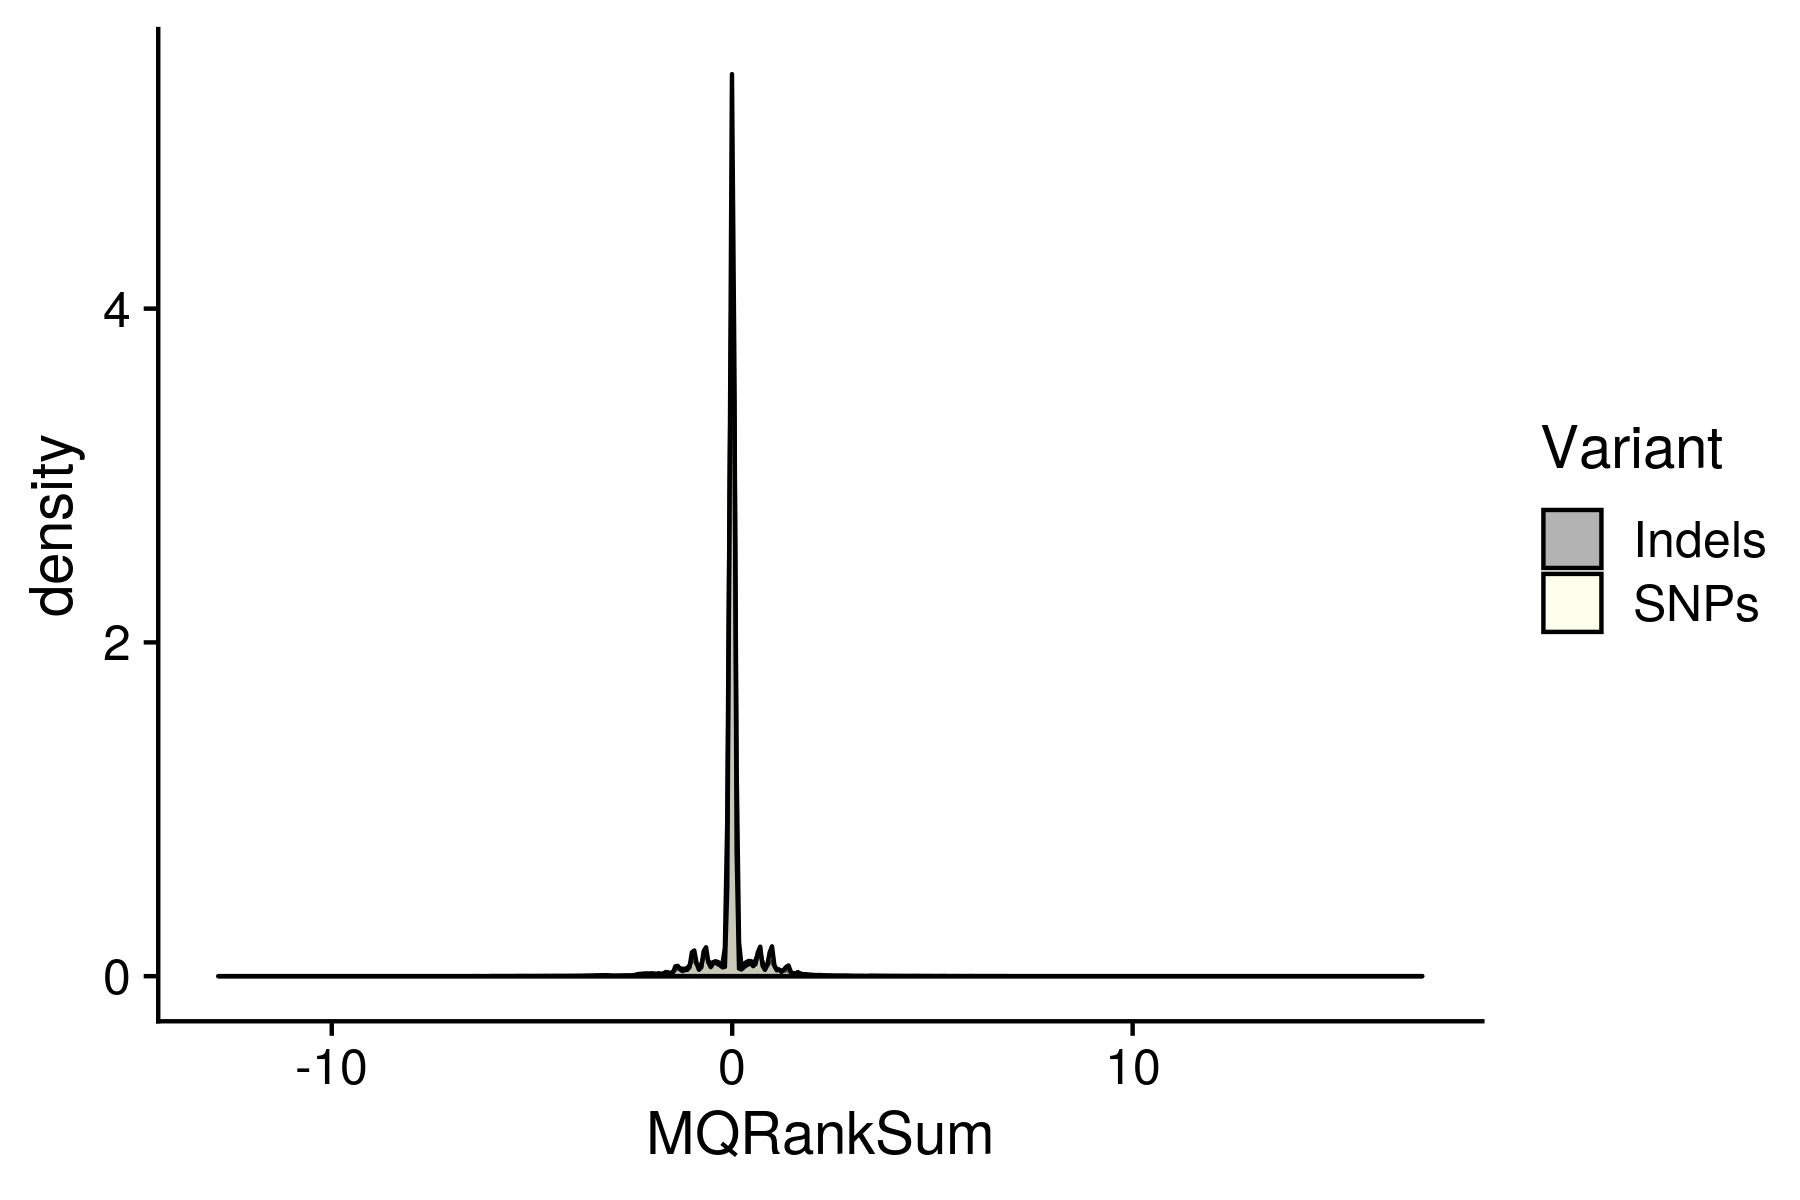

In [10]:
ggplot(VCF, aes(x=MQRankSum, fill=Variant)) +
    geom_density(alpha=.3) +
    scale_fill_viridis(discrete = TRUE, option = "magma")

Plot the test of whether the reads support a SNP call tend to be near the end of a read using a u-based
z-approximation Rank Sum Test for site position. This is the basis of the parameter **ReadPosRankSum** and 
based on this distribution I will use -8.0 < **ReadPosRankSum** < 8.0.

Warning message:
“Removed 6857967 rows containing non-finite values (stat_density).”


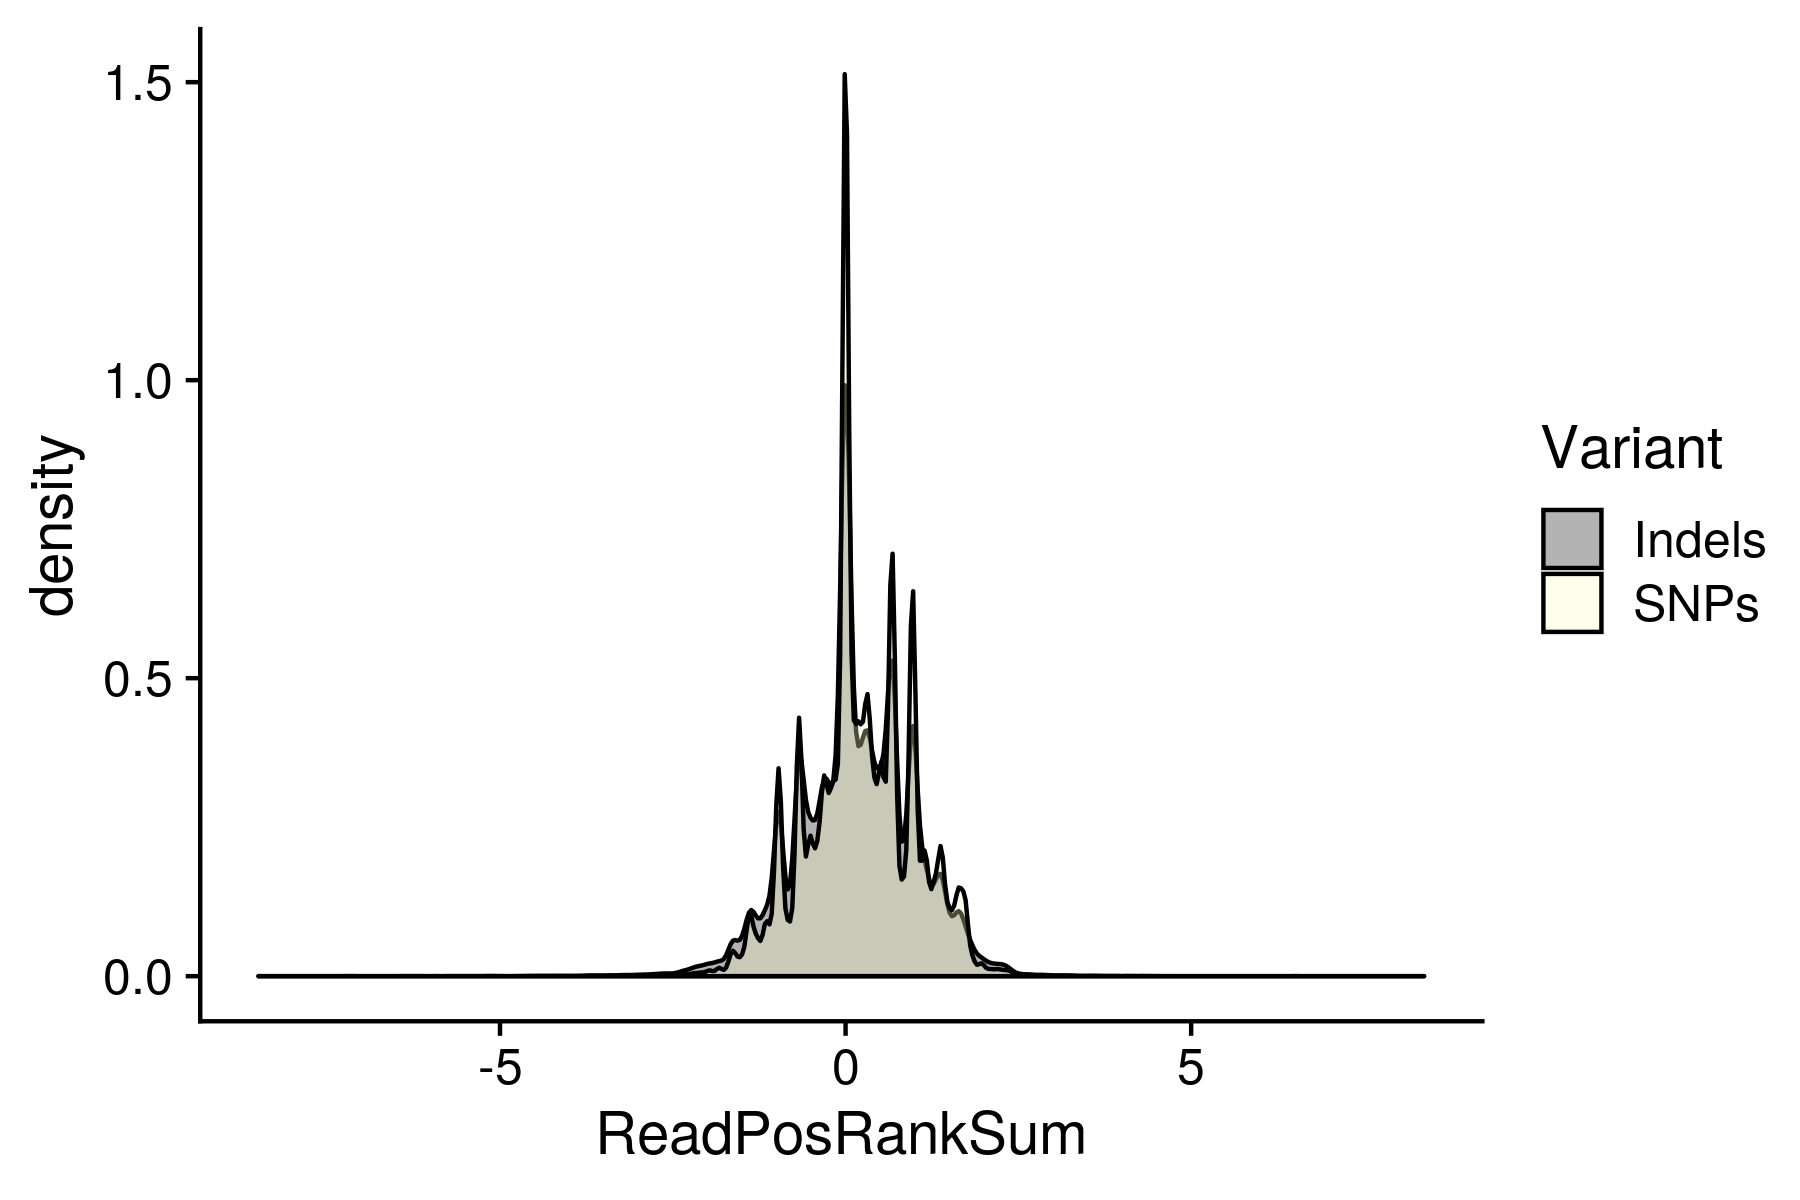

In [11]:
ggplot(VCF, aes(x=ReadPosRankSum, fill=Variant)) +
    geom_density(alpha=.3) +
    scale_fill_viridis(discrete = TRUE, option = "magma")

## Perform hard filtering of SNP sites

Implement all of the filtering criteria determined above:

```bash
# BASH code

gatk VariantFiltration \
    -R Salix_purpurea_var_94006.mainGenome-noZ.fasta \
    -V snigra.genotypes.snp.vcf \
    --filter-expression "MQ < 40.00 || SOR > 3.000 || QD < 2.000 || FS > 60.000 || MQRankSum < -12.500 || ReadPosRankSum < -8.000 || ReadPosRankSum > 8.000" \
    --filter-name "my_snp_filter" \
    -O snigra.genotypes.snp.filter.vcf

sed '/my_snp_filter/d' snigra.genotypes.snp.filter.vcf > snigra.genotypes.snp.filterPASSED.vcf
```

### Quantify per depth per sample to determine criteria for depth filtering of genotypes

Create a table of depth values and genotypes

```bash
# BASH code

gatk VariantsToTable \
     -R Salix_purpurea_var_94006.mainGenome-noZ.fasta \
     -V snigra.genotypes.snp.vcf \
     -F CHROM -F POS -GF GT -GF DP \
     -O snigra.genotypes.snp.DP.table
```

In R, determine quantiles for genotype depth for each sample:

In [12]:
all_frame <- read_delim("snigra.genotypes.snp.DP.table", delim = "\t")

Parsed with column specification:
cols(
  .default = col_character(),
  POS = col_double(),
  SN502F.DP = col_double(),
  SN503M.DP = col_double(),
  SN504F.DP = col_double(),
  SN505F.DP = col_double(),
  SN506F.DP = col_double(),
  SN507M.DP = col_double(),
  SN508F.DP = col_double(),
  SN509F.DP = col_double(),
  SN510F.DP = col_double(),
  SN511F.DP = col_double(),
  SN512F.DP = col_double(),
  SN512bF.DP = col_double(),
  SN513F.DP = col_double(),
  SN514F.DP = col_double(),
  SN515M.DP = col_double(),
  SN516M.DP = col_double(),
  SN517M.DP = col_double(),
  SN518M.DP = col_double(),
  SN519M.DP = col_double()
  # ... with 29 more columns
)

See spec(...) for full column specifications.



Convert depths and genotypes to long-form tables, and replace counts with NA values for positions with no-call "./." genotypes

In [13]:
select(all_frame, CHROM, POS, contains(".DP")) %>%
gather(., "library", "counts", contains(".DP")) %>%
mutate(., library = gsub(".DP", "", library)) -> depth_frame

In [14]:
select(all_frame, CHROM, POS, contains(".GT")) %>%
gather(., "library", "genotype", contains(".GT")) %>%
mutate(., library = gsub(".GT", "", library)) -> gt_frame

In [15]:
describe_frame <- left_join(depth_frame, gt_frame, by = c("CHROM" = "CHROM", "POS" = "POS", "library" = "library"))

In [16]:
mutate(describe_frame, counts = replace(counts, genotype == "./.", NA)) -> describe_frame_sub

### Distribution of read counts across all reads

In [17]:
summarise(describe_frame_sub, "5%" = quantile(counts, 0.05, na.rm =T),
                              "25%" = quantile(counts, 0.25, na.rm =T),
                              "50%" = quantile(counts, 0.5, na.rm =T),
                              "75%" = quantile(counts, 0.75, na.rm =T),
                              "99%" = quantile(counts, 0.99, na.rm =T),
                              "MAX" = max(counts, na.rm = T), 
                              "mean" = exp(mean(log(counts + 1), na.rm =T)) - 1,
                              "sd" = exp(sd(log(counts + 1), na.rm =T)) - 1)

5%,25%,50%,75%,99%,MAX,mean,sd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,4,14,134,3029,6.167386,2.059739


### Distribution of read counts for each library

In [18]:
group_by(describe_frame_sub, library) %>%
summarise(., "5%" = quantile(counts, 0.05, na.rm =T),
                              "25%" = quantile(counts, 0.25, na.rm =T),
                              "50%" = quantile(counts, 0.5, na.rm =T),
                              "75%" = quantile(counts, 0.75, na.rm =T),
                              "99%" = quantile(counts, 0.99, na.rm =T),
                              "MAX" = max(counts, na.rm = T), 
                              "mean" = exp(mean(log(counts + 1), na.rm =T)) - 1,
                              "sd" = exp(sd(log(counts + 1), na.rm =T)) - 1)

library,5%,25%,50%,75%,99%,MAX,mean,sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SN502F,1,2,6,18,132,1887,7.582276,2.058822
SN503M,1,2,4,11,72,1163,5.173783,1.602927
SN504F,1,2,4,10,73,1020,4.943031,1.621598
SN505F,1,2,7,23,202,2538,8.535188,2.514111
SN506F,1,2,7,20,152,1707,7.840466,2.221639
SN507M,1,2,4,15,174,1646,6.072573,2.331873
SN508F,1,2,4,15,194,2506,6.134985,2.447265
SN509F,1,2,5,15,118,1397,6.528778,1.989974
SN510F,1,2,5,16,142,1326,6.431211,2.196116


## Filter genotypes by depth criteria

Based on the quantile distributions of reads across the libraries, I decided to filter for a minimum of 6 reads supporting a genotype, and a maximum of 125 reads supporting a genotype.

```bash
# BASH code

gatk VariantFiltration \
    -R Salix_purpurea_var_94006.mainGenome-noZ.fasta \
    -V snigra.genotypes.snp.filterPASSED.vcf \
    --genotype-filter-expression "DP < 6 || DP > 125" \
    --genotype-filter-name "DP_6-125" \
    -O snigra.genotypes.filterPASSED_DPfilter.vcf
```
From the genotype-depth-filtered VCF, set all genotypes that do not pass the filter to have no call genotypes (./.)

```bash
# BASH code

gatk SelectVariants \
    -R Salix_purpurea_var_94006.mainGenome-noZ.fasta \
    -V snigra.genotypes.snp.filterPASSED_DPfilter.vcf \
    --set-filtered-gt-to-nocall TRUE \
    -O snigra.genotypes.snp.filterPASSED_DPfilter_NoCall.vcf
```